<a href="https://colab.research.google.com/github/FGalvao77/Usando-o-PySpark-no-Google-Colab/blob/main/Usando_o_PySpark_no_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Usando o PySpark no Google Colab**

---



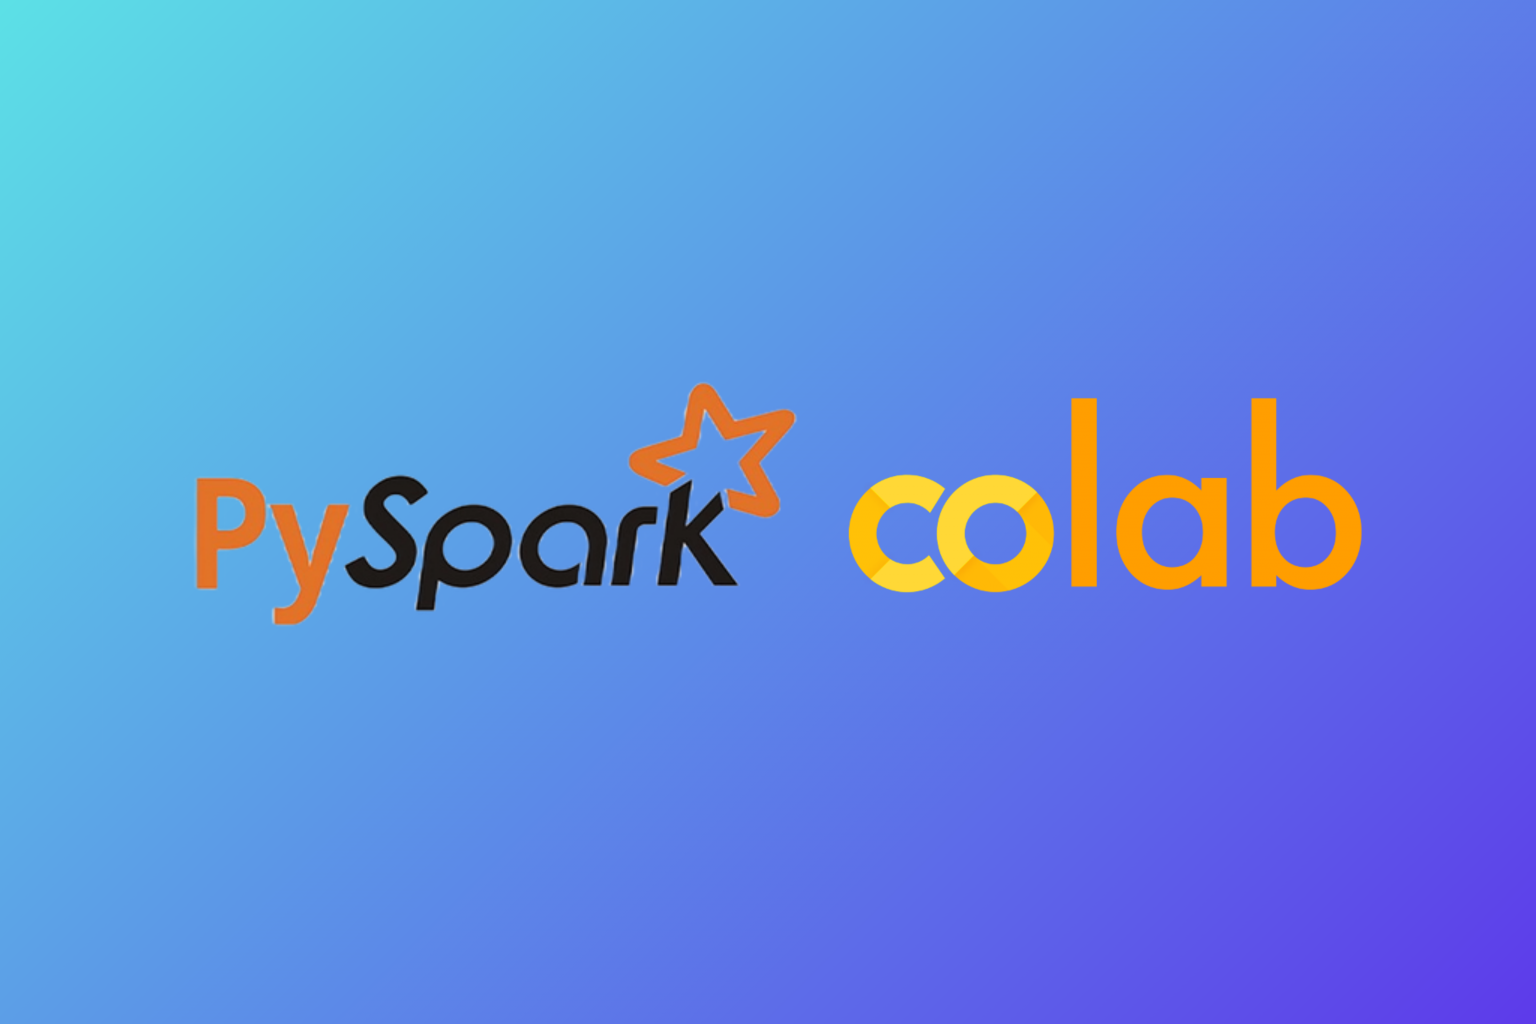

- http://spark.apache.org/docs/latest/api/python/

## **Instalando o `PySpark`, suas dependências e configurando as variáveis de ambiente**

In [541]:
# instalando o pyspark
!pip install pyspark

In [542]:
# instalando as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q pyspark

In [543]:
# configurando as variáveis de ambiente
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop2.7'

# tornando o pyspark "importável"
import findspark
findspark.init()
# findspark.init('spark-3.1.2-bin-hadoop2.7')

## **Machine Learning em Big Data com PySpark**

### **Aprendizagem não-supervisionada com `K-Means`**

#### **Spark MLLIB - Clusterização com K-Means**

**Descrição do algoritmo:**
- algoritmo não-supervisionado
- agrupamento de dados por similaridade
- particiona os dados em um número "k" de clusters, sendo que cada observação pertence apenas a um cluster
- a clusterização é feita medindo a distância entre os pontos de dados e agrupando-os
- múltiplas medidas de distância podem ser usadas, como distância `euclidaiana` e a distância `manhattan`

**Vantagens:**
- veloz
- eficiente quando se tem muitas variáveis

**Desvantagens:**
- o valor de `k` precisa ser conhecido
    - você precisa pelo menos ter uma noção da quantidade de grupos que existem entre si
- o valor inicial de `k` tem influência nos clusters criados  

**Aplicação:**
- agrupamentos preliminar antes de se aplicar técnicas de classificação
    - depois da aplicação do algoritmo você pode aplicar a classificação dentro de outro estudo com algoritmos de aprendizagem supervisionada
- clusterização geográfica, realizar grupos de regiões similares

### **Exemplo prático - agrupando clientes por similaridade**

**Importando as bibliotecas, setando a sessão spark e carregando os dados**

In [544]:
# importando as bibliotecas
import math                                 # para funções matemáticas
import pandas as pd                         # para modelagem de dados
from pyspark.sql import Row                 # para manipulação dos dados com spark com sql
from pyspark.ml.linalg import Vectors       # para criar vetores para uso no k-means
from pyspark.ml.clustering import KMeans    # para realizar o agrupamento dos dados
from pyspark.sql import SparkSession        # para criar a sessão spark
# from pyspark import SparkFiles

import matplotlib.pyplot as plt             # para visualização gráfica

# comando mágico para visualização de gráficos dentro do jupyter notebook
%matplotlib inline

In [545]:
# iniciando uma sessão spark - usamos quando se trabalha com dataframes no spark
spark_session = SparkSession.builder\
        .master('local')\
        .appName('PySpark-GoogleColab')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# visualizando a sessão spark criada
spark_session

In [546]:
# podemos simplificar o código de criação de uma sessão spark
session = SparkSession.builder.master('local[*]')\
        .getOrCreate()

# visualizando a sessão criada
session

In [547]:
# realizando o download do https para arquivo local
!wget --quiet --show-progress https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/master/Datasets/Mall_Customers.csv

# carregando os dados
df_customers = spark_session.read.csv('/content/Mall_Customers.csv', inferSchema=True, header=True)

Mall_Customers.csv. 100%[===================>]   3.89K  --.-KB/s    in 0s      


In [548]:
# outra forma de realizar a leitura do conjunto de dados e baixar o arquivo e carrega-lo no google colab

# importando o conjunto de dados para google colab
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers (1).csv


In [549]:
# depois de carregado o conjunto de dados no google colab
# realizando a leitura e instanciando na variável "df"
df = sc.read.csv('/content/Mall_Customers.csv', inferSchema=True, header=True, sep=',')

**Análise exploratória dos dados**

In [550]:
# visualizando o tipo do objeto da variável "df_customers"
type (df_customers)

pyspark.sql.dataframe.DataFrame

In [551]:
# com a função ".printSchema()" visualizando informações sobre os tipos de dados de cada coluna
df_customers.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [552]:
# tipos de dados no pyspark.sql

# importando a biblioetca
from pyspark.sql import types 

# visualizando os tipos de dados
for t in ['BinaryType', 'BooleanType', 'ByteType', 'DateType', 
          'DecimalType', 'DoubleType', 'FloatType', 'IntegerType', 
           'LongType', 'ShortType', 'StringType', 'TimestampType']:
    print(f"{t}: {getattr(types, t)().simpleString()}")

BinaryType: binary
BooleanType: boolean
ByteType: tinyint
DateType: date
DecimalType: decimal(10,0)
DoubleType: double
FloatType: float
IntegerType: int
LongType: bigint
ShortType: smallint
StringType: string
TimestampType: timestamp


In [553]:
# nome das colunas
df_customers.columns

['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [554]:
# contablilizando a quantidade de colunas
len(df_customers.columns)

5

In [555]:
# visualizando a quantidade de linhas com a função ".count()"
df_customers.count()

200

In [556]:
# visualizando o conjunto de dados em forma de tabela com a função ".show()"
df_customers.show(20) # 20 primeiras linhas

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|         9|  Male| 64|                19|                     3|
|        10|Female| 30|                19|                    72|
|        11|  Male| 67|                19|                    14|
|        12|Female| 35|                19|                    99|
|        1

In [557]:
# podemos usar a função "display()" para exibir
display(df_customers.show())

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|         9|  Male| 64|                19|                     3|
|        10|Female| 30|                19|                    72|
|        11|  Male| 67|                19|                    14|
|        12|Female| 35|                19|                    99|
|        1

None

In [558]:
# visualizando as 5 primeiras linhas com a função ".take()" e passando como argumento o 5
df_customers.take(5)

[Row(CustomerID=1, Gender='Male', Age=19, Annual Income (k$)=15, Spending Score (1-100)=39),
 Row(CustomerID=2, Gender='Male', Age=21, Annual Income (k$)=15, Spending Score (1-100)=81),
 Row(CustomerID=3, Gender='Female', Age=20, Annual Income (k$)=16, Spending Score (1-100)=6),
 Row(CustomerID=4, Gender='Female', Age=23, Annual Income (k$)=16, Spending Score (1-100)=77),
 Row(CustomerID=5, Gender='Female', Age=31, Annual Income (k$)=17, Spending Score (1-100)=40)]

In [559]:
# outra forma de visualizar as 5 primeiras linhas e com a função ".head()"
df_customers.head(5)

[Row(CustomerID=1, Gender='Male', Age=19, Annual Income (k$)=15, Spending Score (1-100)=39),
 Row(CustomerID=2, Gender='Male', Age=21, Annual Income (k$)=15, Spending Score (1-100)=81),
 Row(CustomerID=3, Gender='Female', Age=20, Annual Income (k$)=16, Spending Score (1-100)=6),
 Row(CustomerID=4, Gender='Female', Age=23, Annual Income (k$)=16, Spending Score (1-100)=77),
 Row(CustomerID=5, Gender='Female', Age=31, Annual Income (k$)=17, Spending Score (1-100)=40)]

In [561]:
# visualizando as 5 últimas linhas e com a função ".tail()"
df_customers.tail(5)

[Row(CustomerID=196, Gender='Female', Age=35, Annual Income (k$)=120, Spending Score (1-100)=79),
 Row(CustomerID=197, Gender='Female', Age=45, Annual Income (k$)=126, Spending Score (1-100)=28),
 Row(CustomerID=198, Gender='Male', Age=32, Annual Income (k$)=126, Spending Score (1-100)=74),
 Row(CustomerID=199, Gender='Male', Age=32, Annual Income (k$)=137, Spending Score (1-100)=18),
 Row(CustomerID=200, Gender='Male', Age=30, Annual Income (k$)=137, Spending Score (1-100)=83)]

In [562]:
# instanciando os dados em uma nova variável e gerando um RDD (Resilient Distributed Dataset)
customersRDD = df_customers
customersRDD.cache()   # definindo que, todo processamento dos dados será executado na memória cache

DataFrame[CustomerID: int, Gender: string, Age: int, Annual Income (k$): int, Spending Score (1-100): int]

In [563]:
# visualizando as 5 primeiras linhas
customersRDD.show(5)

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
+----------+------+---+------------------+----------------------+
only showing top 5 rows



In [564]:
# visualizando a quantidade e o nome das colunas
len(customersRDD.columns), customersRDD.columns

(5,
 ['CustomerID',
  'Gender',
  'Age',
  'Annual Income (k$)',
  'Spending Score (1-100)'])

In [565]:
# contabilizando a quantidade de linhas
customersRDD.count()

200

In [566]:
# visualizando instâncias únicas da coluna "Gender"
customersRDD.select('Gender').distinct().show()

+------+
|Gender|
+------+
|Female|
|  Male|
+------+



In [567]:
# contabilizando a distribuição das instâncias da variável "Gender"

# importando a função
from pyspark.sql import functions as F

customersRDD.groupBy('Gender').agg(F.count('CustomerID')).show()

+------+-----------------+
|Gender|count(CustomerID)|
+------+-----------------+
|Female|              112|
|  Male|               88|
+------+-----------------+



In [568]:
# contabilizando o rendimento anual médio por gênero sexual

# importando a função
from pyspark.sql import functions as F

# customersRDD.groupBy('Gender').agg(F.mean('Annual Income (k$)')).show()
customersRDD.groupBy('Gender').agg(F.mean('Annual Income (k$)')).sort('Gender', 
                                                                   ascending=False).show()

+------+-----------------------+
|Gender|avg(Annual Income (k$))|
+------+-----------------------+
|  Male|      62.22727272727273|
|Female|                  59.25|
+------+-----------------------+



In [570]:
# contabilizando o rendimento anual pela média da idade

# importando a função
from pyspark.sql import functions as F

# customersRDD.groupBy('Age').agg(F.mean('Annual Income (k$)')).show()
customersRDD.groupBy('Annual Income (k$)').agg(F.mean('Age')).sort('Annual Income (k$)', 
                                                                   ascending=False).show()

+------------------+------------------+
|Annual Income (k$)|          avg(Age)|
+------------------+------------------+
|               137|              31.0|
|               126|              38.5|
|               120|              41.0|
|               113|              35.5|
|               103|             35.75|
|               101|              41.0|
|                99|              35.5|
|                98|              37.5|
|                97|              34.5|
|                93|              47.0|
|                88|             41.75|
|                87|34.666666666666664|
|                86|              37.5|
|                85|              43.0|
|                81|              25.0|
|                79|              42.5|
|                78|36.416666666666664|
|                77|             33.25|
|                76|              30.0|
|                75|              44.5|
+------------------+------------------+
only showing top 20 rows



In [571]:
# contabilizando a média da pontuação de gastos por gênero sexual

# importando a função
from pyspark.sql import functions as F

customersRDD.groupBy('Gender').agg(F.mean('Spending Score (1-100)')).show()

+------+---------------------------+
|Gender|avg(Spending Score (1-100))|
+------+---------------------------+
|Female|         51.526785714285715|
|  Male|          48.51136363636363|
+------+---------------------------+



In [572]:
# contabilizando a pontuação de gastos por média da idade

# importando a função
from pyspark.sql import functions as F

# customersRDD.groupBy('Age').agg(F.mean('Spending Score (1-100)')).show()
customersRDD.groupBy('Spending Score (1-100)').agg(F.mean('Age')).sort('Spending Score (1-100)', 
                                                                   ascending=False).show()

+----------------------+------------------+
|Spending Score (1-100)|          avg(Age)|
+----------------------+------------------+
|                    99|              35.0|
|                    98|              35.0|
|                    97|              29.0|
|                    95|              36.5|
|                    94|              23.0|
|                    93|              31.5|
|                    92|              26.0|
|                    91|              38.5|
|                    90|              34.5|
|                    89|              27.0|
|                    88|32.333333333333336|
|                    87|              27.5|
|                    86|              31.0|
|                    85|              36.0|
|                    83|              29.5|
|                    82|              29.0|
|                    81|              21.0|
|                    79|              28.5|
|                    78|              30.0|
|                    77|        

In [573]:
# visualizando dados estatísticos
customersRDD.describe().show()

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID|Gender|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  null|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  null|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



In [574]:
# visualizando dados estatísticos da coluna "Annual Income (k$)" (rendimento anual)
customersRDD.select('Annual Income (k$)').describe().show()

+-------+------------------+
|summary|Annual Income (k$)|
+-------+------------------+
|  count|               200|
|   mean|             60.56|
| stddev| 26.26472116527124|
|    min|                15|
|    max|               137|
+-------+------------------+



In [575]:
# visualizando dados estatísticos
# colunas "Annual Income (k$)" (rendimento anual) | "Spending Score (1-100)" (oontuação de gastos)
customersRDD.select('Annual Income (k$)', 'Spending Score (1-100)').describe().show()

+-------+------------------+----------------------+
|summary|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+----------------------+
|  count|               200|                   200|
|   mean|             60.56|                  50.2|
| stddev| 26.26472116527124|    25.823521668370173|
|    min|                15|                     1|
|    max|               137|                    99|
+-------+------------------+----------------------+



In [576]:
# visualizando dados estatísticos somente da coluna "Age" (idade)
customersRDD.select('Age').describe().show()

+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|              200|
|   mean|            38.85|
| stddev|13.96900733155888|
|    min|               18|
|    max|               70|
+-------+-----------------+



In [577]:
# verificando a existência ou não de valores nulos no conjunto de dados

# importando as funções
from pyspark.sql.functions import isnan, when, count, col

customersRDD.select([count(when(isnan(c), c)).
                     alias(c) for c in customersRDD.
                     columns]).show()

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         0|     0|  0|                 0|                     0|
+----------+------+---+------------------+----------------------+



In [578]:
# verificando se há valores ausentes e removendo-os, se houver

# importando a função
from pyspark.sql import functions as F

customersRDD.select([F.count(F.when(F.isnull(c), c)).
                     alias(c) for c in customersRDD.
                     columns]).show()

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         0|     0|  0|                 0|                     0|
+----------+------+---+------------------+----------------------+



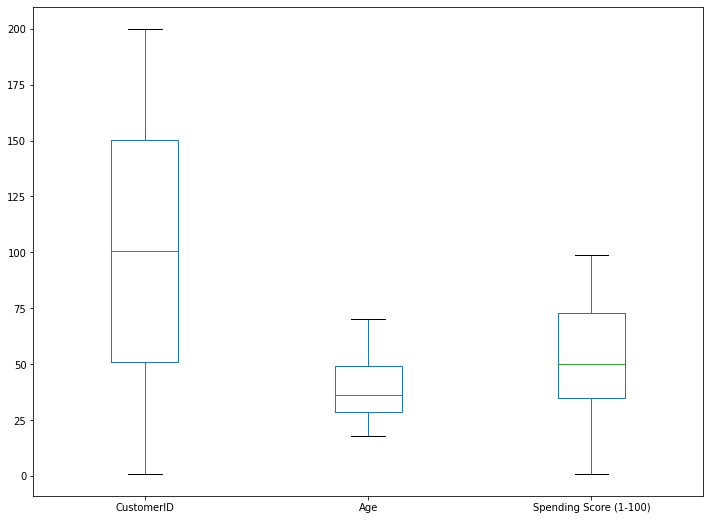

In [670]:
# gender = customersRDD.select(['Gender', 'Annual Income (k$)']).show()
customersRDD.toPandas().plot.box(x='Annual Income (k$)', figsize=(12, 9));

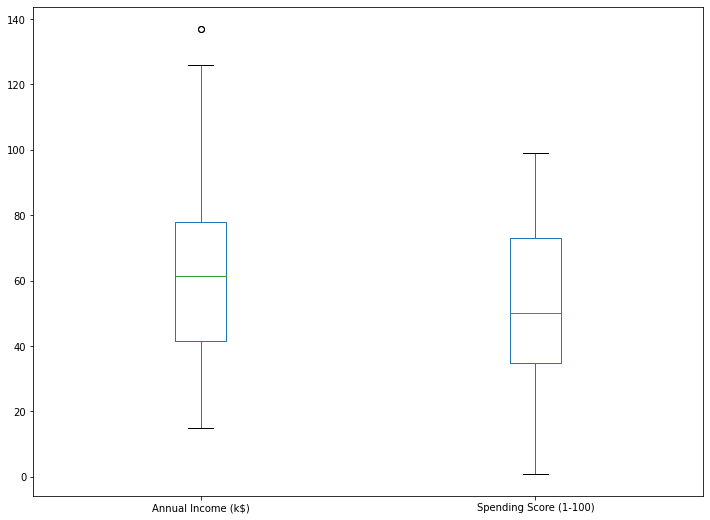

In [671]:
# verificando se há outliers (anomalias) nos dados
customersRDD_outliers = customersRDD.select([c for c in customersRDD.columns if c in ['Age', 
                                                                                      'Annual Income (k$)', 
                                                                                      'Spending Score (1-100)']])

# visualizando o boxplot
customersRDD_outliers.toPandas().plot.box(x='Age', figsize=(12, 9));

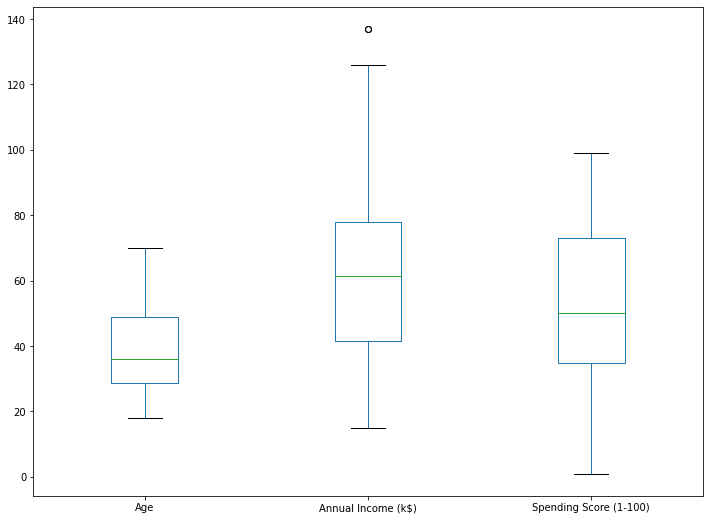

In [672]:
# plotando o gráfico boxplot
customersRDD.toPandas().plot.box(x='CustomerID', figsize=(12, 9));

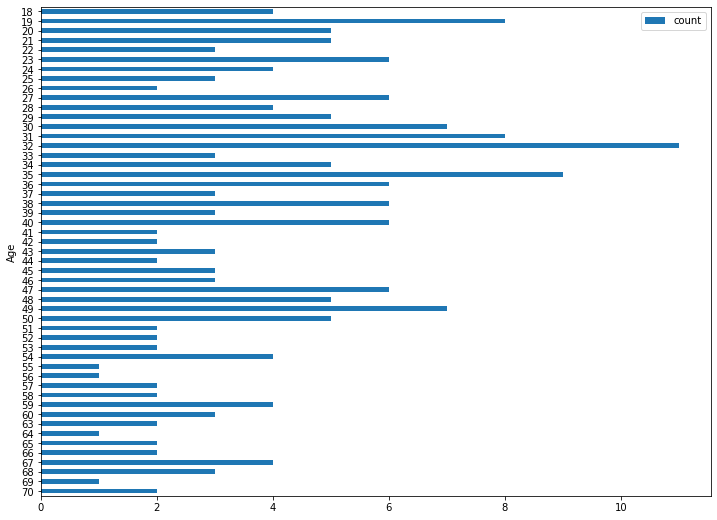

In [669]:
# plotando gráfico de barras da distribuição das idades
age_df = customersRDD.groupBy('Age').count().sort('Age', ascending=False)
age_df.toPandas().plot.barh(x='Age', figsize=(12, 9));

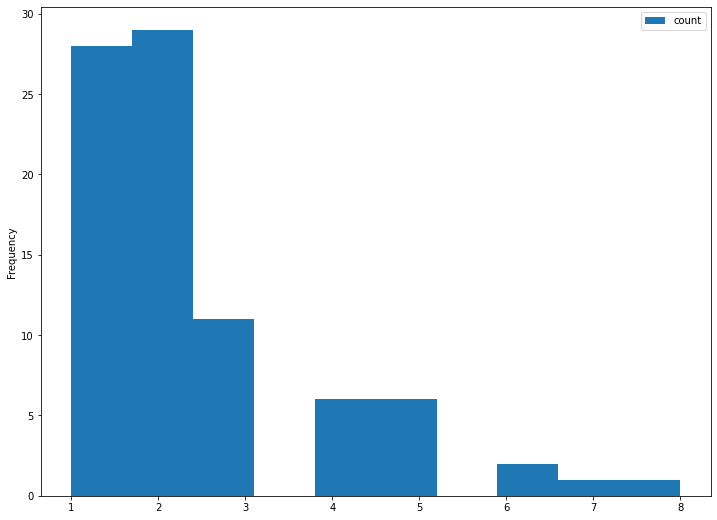

In [673]:
# plotando gráfico de histograma da pontução de gastos
score_df = customersRDD.groupBy('Spending Score (1-100)').count().sort('Spending Score (1-100)', ascending=False)
score_df.toPandas().plot.hist(x='Spending Score (1-100)', bins=10, figsize=(12, 9));

In [584]:
# visualizando os valores da variável "Age" (idade)
# maior, menor, média e desvio-padrão

# importando as funções
from pyspark.sql.functions import max, min, sum, mean, stddev

print(customersRDD.select(max('Age')).take(1))
print(customersRDD.select(min('Age')).take(1))
print(customersRDD.select(mean('Age')).take(1))
print(customersRDD.select(stddev('Age')).take(1))

[Row(max(Age)=70)]
[Row(min(Age)=18)]
[Row(avg(Age)=38.85)]
[Row(stddev_samp(Age)=13.96900733155888)]


In [585]:
# importando a biblioteca para análise estatísticas
from pyspark.mllib.stat import Statistics as Stat

In [586]:
# analisando a correlação entre "Age" (idade) e "Spending Score (1-100)" (pontuação)

# criando as seleções para análise
rdd_1 = customersRDD.select('Spending Score (1-100)').rdd.flatMap(lambda x: x)
rdd_2 = customersRDD.select('Age').rdd.flatMap(lambda x: x)

In [593]:
# visualizando a correlação
# usando o apelido ("Stat") atribuido ao "Statistics"
Stat.corr(rdd_1, rdd_2, method='pearson')

-0.32722684603909014

In [594]:
# podemos realizar a correlação passando como argumentos as variáveis
# visualizando a correlação entre as variáveis "Spending Score (1-100)" e "Age"
customersRDD.stat.corr('Spending Score (1-100)', 'Age', method='pearson')

-0.32722684603909025

In [595]:
# visualizando a correlação entre as variáveis "Age" e "Annual Income (k$)"
customersRDD.stat.corr('Age', 'Annual Income (k$)', method='pearson')

-0.01239804273606026

In [599]:
# visualizando a correlação entre as variáveis "Age" e "Spending Score (1-100)"
customersRDD.stat.corr('Age', 'Spending Score (1-100)', method='pearson')

-0.32722684603909025

In [607]:
# analisando a correlação por gênero - "Male" (homem) e "Female" (mulher)

# criando as seleções
men = customersRDD[customersRDD.Gender == 'Male']       # homens
women = customersRDD[customersRDD.Gender == 'Female']   # mulheres

In [606]:
# contabilizando as instâncias nas variáveis "man" e women
men.count(), women.count()

(88, 112)

In [609]:
# correlação entre idade e o salário anual - homens
men.stat.corr('Age', 'Annual Income (k$)', method='pearson')

-0.0929780930108071

In [610]:
# correlação entre idade e o salário anual - mulheres
women.stat.corr('Age', 'Annual Income (k$)', method='pearson')

0.059912127894555724

In [612]:
# correlação entre idade e a pontuação de gastos - homens
men.stat.corr('Age', 'Spending Score (1-100)', method='pearson')

-0.27962764627493125

In [613]:
# correlação entre idade e a pontuação de gastos - mulheres
women.stat.corr('Age', 'Spending Score (1-100)', method='pearson')

-0.3754385837780473

In [614]:
# correlação entre pontuação de gastos e o salário anual - homens
men.stat.corr('Spending Score (1-100)', 'Annual Income (k$)', method='pearson')

-0.02368420375597224

In [615]:
# correlação entre pontuação de gastos e o salário anual - mulheres
women.stat.corr('Spending Score (1-100)', 'Annual Income (k$)', method='pearson')

0.047542116949039134

**Aplicando o `K-Means`**

In [616]:
# importando as bibliotecas
from pyspark.ml.evaluation import ClusteringEvaluator   # para a avaliação em cada um dos clusters
from pyspark.ml.clustering import KMeans                # para a criação do modelo de clusterização utilizando o K-means
from pyspark.ml.feature import VectorAssembler          # para transformar os dados em vetores de características 

In [617]:
# criando um vetor

vecAssembler = VectorAssembler(inputCols=['Spending Score (1-100)', 'Annual Income (k$)'], 
                               outputCol='features')    # utilizada para transformar os dados em um vetor (define o objeto)

new_df = vecAssembler.transform(customersRDD)   # aplicando a transformação

# visualizando a variável
new_df.show()

+----------+------+---+------------------+----------------------+-----------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|   features|
+----------+------+---+------------------+----------------------+-----------+
|         1|  Male| 19|                15|                    39|[39.0,15.0]|
|         2|  Male| 21|                15|                    81|[81.0,15.0]|
|         3|Female| 20|                16|                     6| [6.0,16.0]|
|         4|Female| 23|                16|                    77|[77.0,16.0]|
|         5|Female| 31|                17|                    40|[40.0,17.0]|
|         6|Female| 22|                17|                    76|[76.0,17.0]|
|         7|Female| 35|                18|                     6| [6.0,18.0]|
|         8|Female| 23|                18|                    94|[94.0,18.0]|
|         9|  Male| 64|                19|                     3| [3.0,19.0]|
|        10|Female| 30|                19|                    72

In [618]:
# aplicando o processo de clusterização

# definindo a quantidade de clusters e a semente de aleatoriedade
kmeans = KMeans(k=5, seed=111)  # cluster de 5 | seed de 111

# realizando o treinamento do modelo
model = kmeans.fit(new_df.select('features'))

In [619]:
# criando um dataset com a indicação sobre qual cluster
# que cada instância foi definida
df_final = model.transform(new_df)
df_final.show()

+----------+------+---+------------------+----------------------+-----------+----------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|   features|prediction|
+----------+------+---+------------------+----------------------+-----------+----------+
|         1|  Male| 19|                15|                    39|[39.0,15.0]|         2|
|         2|  Male| 21|                15|                    81|[81.0,15.0]|         0|
|         3|Female| 20|                16|                     6| [6.0,16.0]|         2|
|         4|Female| 23|                16|                    77|[77.0,16.0]|         0|
|         5|Female| 31|                17|                    40|[40.0,17.0]|         2|
|         6|Female| 22|                17|                    76|[76.0,17.0]|         0|
|         7|Female| 35|                18|                     6| [6.0,18.0]|         2|
|         8|Female| 23|                18|                    94|[94.0,18.0]|         0|
|         9|  Male| 6

In [620]:
# contabilizando a quantidade de instâncias de cada cluster
# df_final.groupby('prediction').count().show()
df_final.groupby('prediction').count().sort('prediction', ascending=True).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   96|
|         1|   26|
|         2|   23|
|         3|   17|
|         4|   38|
+----------+-----+



In [621]:
# transformando os dados em um dataframe do pandas 
data_pandas = df_final.toPandas().set_index('CustomerID')
data_pandas.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),features,prediction
CustomerID,,,,,,
1,Male,19,15,39,"[39.0, 15.0]",2
2,Male,21,15,81,"[81.0, 15.0]",0
3,Female,20,16,6,"[6.0, 16.0]",2
4,Female,23,16,77,"[77.0, 16.0]",0
5,Female,31,17,40,"[40.0, 17.0]",2


In [622]:
# transformando os dados em um dataframe do pandas 
data_pandas = df_final.toPandas()   # não setando o índice
data_pandas.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),features,prediction
0,1,Male,19,15,39,"[39.0, 15.0]",2
1,2,Male,21,15,81,"[81.0, 15.0]",0
2,3,Female,20,16,6,"[6.0, 16.0]",2
3,4,Female,23,16,77,"[77.0, 16.0]",0
4,5,Female,31,17,40,"[40.0, 17.0]",2


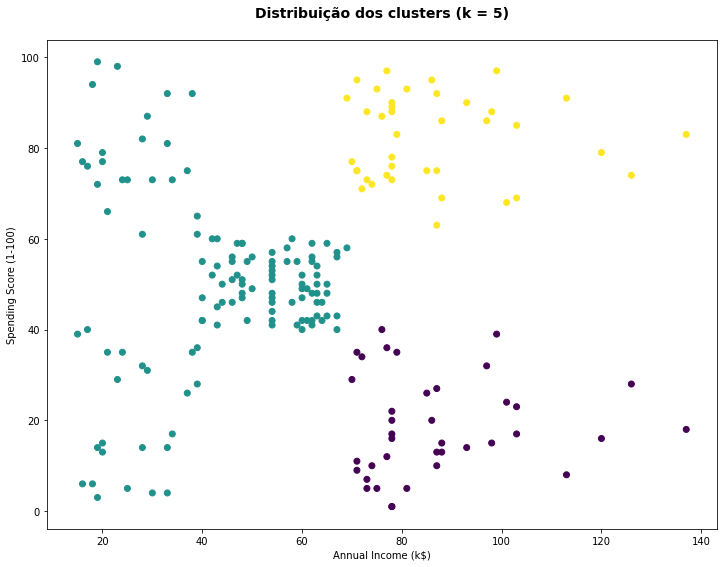

In [674]:
# importando a biblioteca
import matplotlib.pyplot as plt     # para visualização gráfica

# comando mágico para visualização de gráficos dentro do jupyter notebook
%matplotlib inline

plt.figure(figsize=(12, 9))
plt.scatter(data_pandas['Annual Income (k$)'], data_pandas['Spending Score (1-100)'], 
            c=data_pandas.prediction)

plt.title('Distribuição dos clusters (k = 5)\n', 
         {'fontsize': 14,'fontweight': 'bold'})

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.show();

In [624]:
# aplicando o processo de clusterização

# definindo a quantidade de clusters e a semente de aleatoriedade
kmeans = KMeans(k=3, seed=111)  # cluster de 3 | seed de 111

# realizando o treinamento do modelo
model = kmeans.fit(new_df.select('features'))

In [625]:
# criando um dataset com a indicação sobre qual cluster
# que cada instância foi definida
df_final = model.transform(new_df)
df_final.show()

+----------+------+---+------------------+----------------------+-----------+----------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|   features|prediction|
+----------+------+---+------------------+----------------------+-----------+----------+
|         1|  Male| 19|                15|                    39|[39.0,15.0]|         1|
|         2|  Male| 21|                15|                    81|[81.0,15.0]|         1|
|         3|Female| 20|                16|                     6| [6.0,16.0]|         1|
|         4|Female| 23|                16|                    77|[77.0,16.0]|         1|
|         5|Female| 31|                17|                    40|[40.0,17.0]|         1|
|         6|Female| 22|                17|                    76|[76.0,17.0]|         1|
|         7|Female| 35|                18|                     6| [6.0,18.0]|         1|
|         8|Female| 23|                18|                    94|[94.0,18.0]|         1|
|         9|  Male| 6

In [626]:
# contabilizando a quantidade de instâncias de cada cluster
# df_final.groupby('prediction').count().show()
df_final.groupby('prediction').count().sort('prediction', ascending=True).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   38|
|         1|  123|
|         2|   39|
+----------+-----+



In [627]:
# transformando os dados em um dataframe do pandas 
data_pandas = df_final.toPandas()   # não setando o índice
data_pandas.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),features,prediction
0,1,Male,19,15,39,"[39.0, 15.0]",1
1,2,Male,21,15,81,"[81.0, 15.0]",1
2,3,Female,20,16,6,"[6.0, 16.0]",1
3,4,Female,23,16,77,"[77.0, 16.0]",1
4,5,Female,31,17,40,"[40.0, 17.0]",1


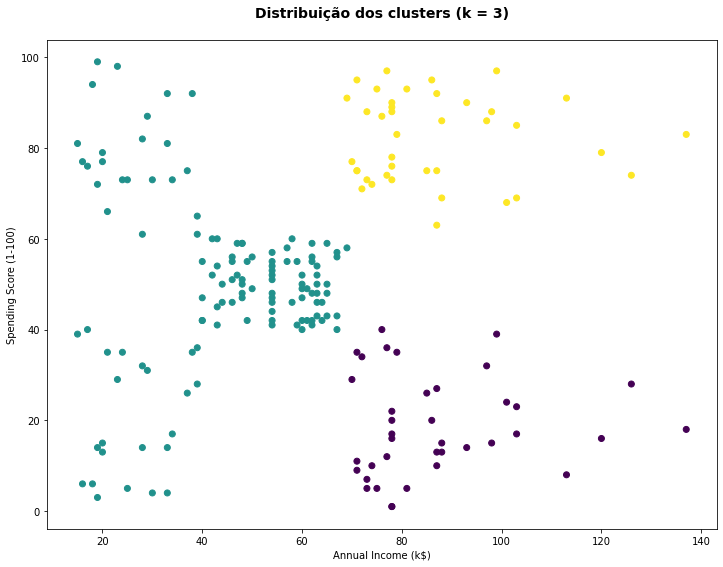

In [675]:
# importando a biblioteca
import matplotlib.pyplot as plt     # para visualização gráfica

# comando mágico para visualização de gráficos dentro do jupyter notebook
%matplotlib inline

plt.figure(figsize=(12, 9))
plt.scatter(data_pandas['Annual Income (k$)'], data_pandas['Spending Score (1-100)'], 
            c=data_pandas.prediction)

plt.title('Distribuição dos clusters (k = 3)\n', 
         {'fontsize': 14,'fontweight': 'bold'})

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show();

### **Exemplo prático - agrupando carros por similaridade**

In [629]:
# importando as bibliotecas
import math                                 # para funções matemáticas
import pandas as pd                         # para modelagem de dados
from pyspark.sql import Row                 # para manipulação dos dados com spark
from pyspark.ml.linalg import Vectors       # para criar vetores para uso no k-means
from pyspark.ml.clustering import KMeans    # para realizar o agrupamento dos dados
from pyspark.sql import SparkSession        # para criar a sessão spark
# from pyspark import SparkFiles

import matplotlib.pyplot as plt             # para visualização gráfica

# comando mágico para visualização de gráficos dentro do jupyter notebook
%matplotlib inline

In [630]:
# iniciando uma sessão spark 
spark = SparkSession.builder.master('local[*]')\
        .getOrCreate()

# visualizando a sessão criada
spark

In [631]:
# realizando o download do https para arquivo local
!wget --quiet --show-progress https://raw.githubusercontent.com/milan8866/Data-clustering/master/cars_dataset.csv

cars_dataset.csv.1  100%[===================>]  18.03K  --.-KB/s    in 0s      


In [632]:
# carregando os dados
df_cars = spark.read.csv('/content/cars_dataset.csv', inferSchema=True, header=True, sep=',')

**Análise exploratória dos dados**

In [633]:
# visualizando informações sobre os tipos de dados de cada coluna
df_cars.printSchema()

root
 |-- Model: string (nullable = true)
 |-- MPG: double (nullable = true)
 |-- Cylinders: integer (nullable = true)
 |-- Displacement: double (nullable = true)
 |-- Horsepower: string (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Acceleration: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Origin: string (nullable = true)



In [634]:
# visualizando o tipo de objeto criado
type (df_cars)

pyspark.sql.dataframe.DataFrame

In [635]:
# visualizando a quantidade de linhas
df_cars.count()

394

In [636]:
# visualizando a quantidade e o nome das colunas
len(df_cars.columns), df_cars.columns

(9,
 ['Model',
  'MPG',
  'Cylinders',
  'Displacement',
  'Horsepower',
  'Weight',
  'Acceleration',
  'Year',
  'Origin'])

In [637]:
# visualizando as 5 primeiras linhas
df_cars.take(5)

[Row(Model='chevrolet chevelle malibu', MPG=18.0, Cylinders=8, Displacement=307.0, Horsepower='130', Weight=3504, Acceleration=12.0, Year=70, Origin='US'),
 Row(Model='buick skylark 320', MPG=15.0, Cylinders=8, Displacement=350.0, Horsepower='165', Weight=3693, Acceleration=11.5, Year=70, Origin='US'),
 Row(Model='plymouth satellite', MPG=18.0, Cylinders=8, Displacement=318.0, Horsepower='150', Weight=3436, Acceleration=11.0, Year=70, Origin='US'),
 Row(Model='amc rebel sst', MPG=16.0, Cylinders=8, Displacement=304.0, Horsepower='150', Weight=3433, Acceleration=12.0, Year=70, Origin='US'),
 Row(Model='ford torino', MPG=17.0, Cylinders=8, Displacement=302.0, Horsepower='140', Weight=3449, Acceleration=10.5, Year=70, Origin='US')]

In [638]:
# visualizando as 5 primeiras linhas em formato de tabela
df_cars.show(5)

+--------------------+----+---------+------------+----------+------+------------+----+------+
|               Model| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Year|Origin|
+--------------------+----+---------+------------+----------+------+------------+----+------+
|chevrolet chevell...|18.0|        8|       307.0|       130|  3504|        12.0|  70|    US|
|   buick skylark 320|15.0|        8|       350.0|       165|  3693|        11.5|  70|    US|
|  plymouth satellite|18.0|        8|       318.0|       150|  3436|        11.0|  70|    US|
|       amc rebel sst|16.0|        8|       304.0|       150|  3433|        12.0|  70|    US|
|         ford torino|17.0|        8|       302.0|       140|  3449|        10.5|  70|    US|
+--------------------+----+---------+------------+----------+------+------------+----+------+
only showing top 5 rows



In [639]:
# importando a função
from pyspark.sql import functions as F

In [640]:
# contabilizando dados faltantes
df_cars.select([F.count(F.when(F.isnull(c), c)).
                alias(c) for c in df_cars.columns]).show()

+-----+---+---------+------------+----------+------+------------+----+------+
|Model|MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Year|Origin|
+-----+---+---------+------------+----------+------+------------+----+------+
|    0|  0|        0|           0|         0|     0|           0|   0|     0|
+-----+---+---------+------------+----------+------+------------+----+------+



In [641]:
# contabilizando dados nulos
df_cars.select([F.count(F.when(F.isnan(c), c)).
                alias(c) for c in df_cars.columns]).show()

+-----+---+---------+------------+----------+------+------------+----+------+
|Model|MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Year|Origin|
+-----+---+---------+------------+----------+------+------------+----+------+
|    0|  0|        0|           0|         0|     0|           0|   0|     0|
+-----+---+---------+------------+----------+------+------------+----+------+



In [642]:
# instanciando os dados em uma nova variável e gerando um RDD (Resilient Distributed Dataset)
carsRDD = df_cars
carsRDD.cache()   # definindo que, todo processamento dos dados será executado na memória cache

DataFrame[Model: string, MPG: double, Cylinders: int, Displacement: double, Horsepower: string, Weight: int, Acceleration: double, Year: int, Origin: string]

In [643]:
# dados estatísticos
carsRDD.describe().show()

+-------+--------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------+
|summary|               Model|              MPG|         Cylinders|      Displacement|        Horsepower|           Weight|      Acceleration|              Year|Origin|
+-------+--------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------+
|  count|                 394|              394|               394|               394|               394|              394|               394|               394|   394|
|   mean|                null|23.47284263959391| 5.464467005076142|194.06218274111674|104.46938775510205|2976.060913705584|15.554568527918766| 76.00761421319797|  null|
| stddev|                null|7.805051443209992|1.7046579937039847|104.50834519343826| 38.49115993282846| 847.891143179426|2.7631788202164884|3.69546078667

In [644]:
# verificando se há valores ausentes e removendo-os, se houver

# importando a função
from pyspark.sql import functions as F

carsRDD.select([F.count(F.when(F.isnull(c), c)).
                     alias(c) for c in carsRDD.
                     columns]).show()

+-----+---+---------+------------+----------+------+------------+----+------+
|Model|MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Year|Origin|
+-----+---+---------+------------+----------+------+------------+----+------+
|    0|  0|        0|           0|         0|     0|           0|   0|     0|
+-----+---+---------+------------+----------+------+------------+----+------+



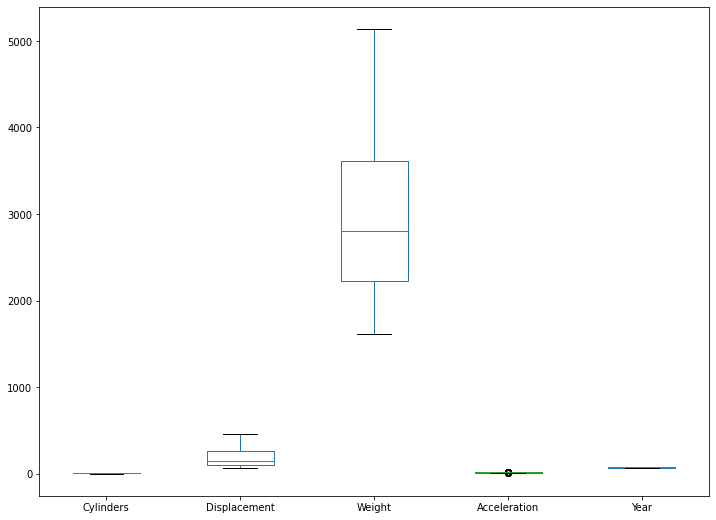

In [676]:
# plotando o gráfico boxplot
carsRDD.toPandas().plot.box(x='MPG', figsize=(12, 9));

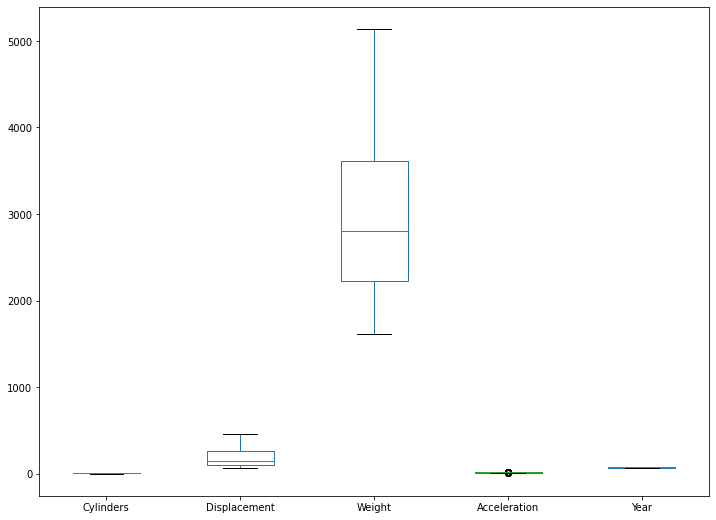

In [677]:
# verificando se há outliers (anomalias) nos dados
carsRDD_outliers = carsRDD.select([c for c in carsRDD.columns if c in ['MPG', 'Cylinders', 'Displacement', 
                                                                       'Weight', 'Acceleration', 'Year']])

# visualizando o boxplot
carsRDD_outliers.toPandas().plot.box(x='MPG', figsize=(12, 9));

In [648]:
# verificando se há outliers (anomalias) nos dados
carsRDD_outliers2 = carsRDD.select([c for c in carsRDD.columns if c in ['MPG', 'Cylinders', 
                                                                        'Acceleration', 'Year']])

carsRDD_outliers3 = carsRDD.select([c for c in carsRDD.columns if c in ['MPG', 'Cylinders']])

carsRDD_outliers4 = carsRDD.select([c for c in carsRDD.columns if c in ['MPG', 'Displacement']])

carsRDD_outliers5 = carsRDD.select([c for c in carsRDD.columns if c in ['MPG', 'Weight']])

carsRDD_outliers6 = carsRDD.select([c for c in carsRDD.columns if c in ['MPG', 'Acceleration']])

carsRDD_outliers7 = carsRDD.select([c for c in carsRDD.columns if c in ['MPG', 'Year']])

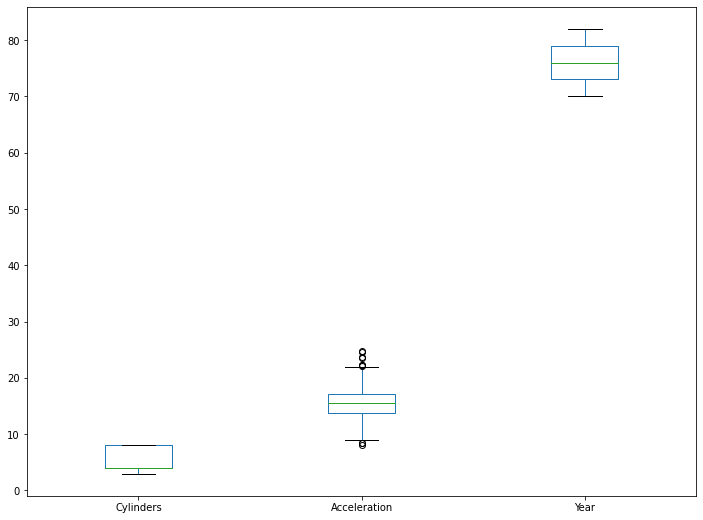

In [678]:
# visualizando o boxplot
carsRDD_outliers2.toPandas().plot.box(x='MPG', figsize=(12, 9));

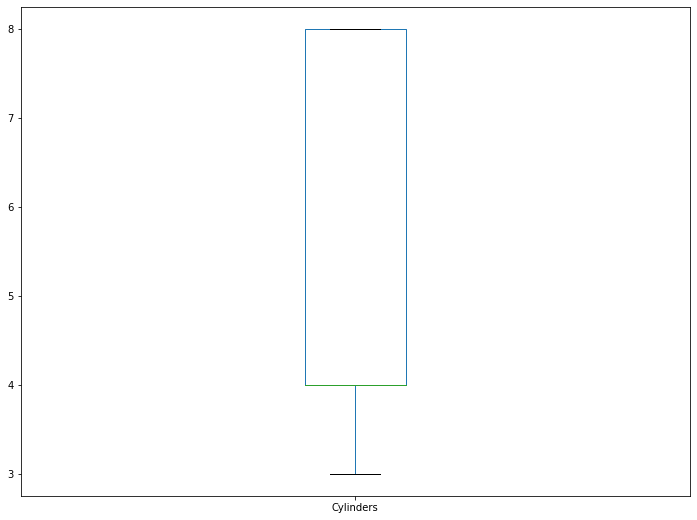

In [679]:
# visualizando o boxplot
carsRDD_outliers3.toPandas().plot.box(x='MPG', figsize=(12, 9));

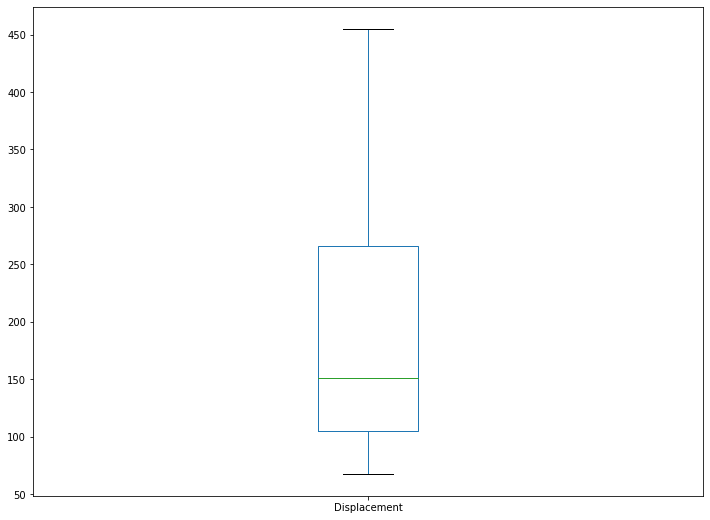

In [680]:
# visualizando o boxplot
carsRDD_outliers4.toPandas().plot.box(x='MPG', figsize=(12, 9));

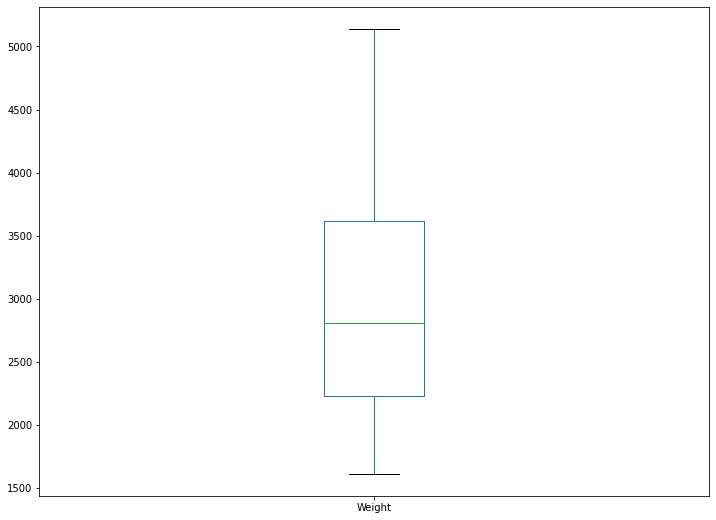

In [681]:
# visualizando o boxplot
carsRDD_outliers5.toPandas().plot.box(x='MPG', figsize=(12, 9));

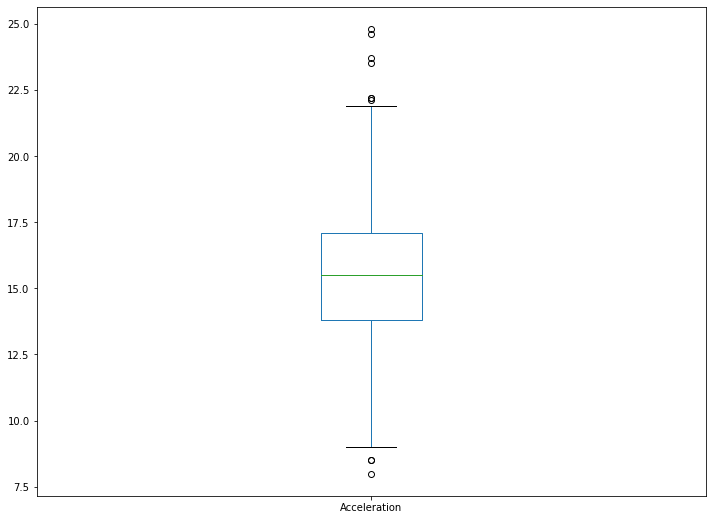

In [682]:
# visualizando o boxplot
carsRDD_outliers6.toPandas().plot.box(x='MPG', figsize=(12, 9));

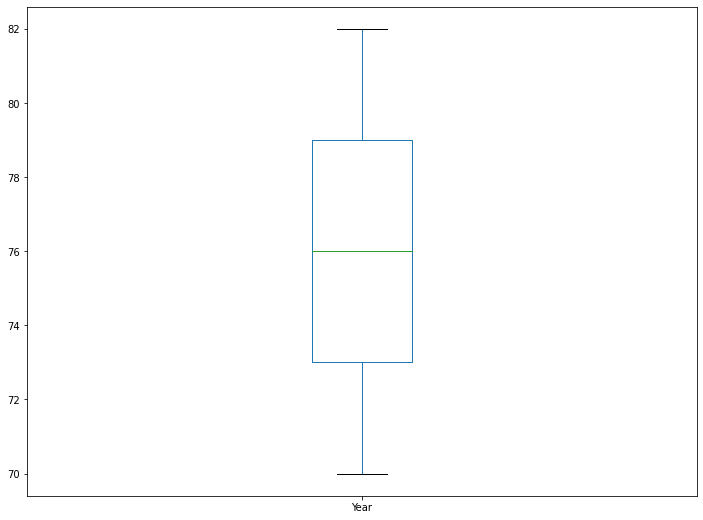

In [683]:
# visualizando o boxplot
carsRDD_outliers7.toPandas().plot.box(x='MPG', figsize=(12, 9));

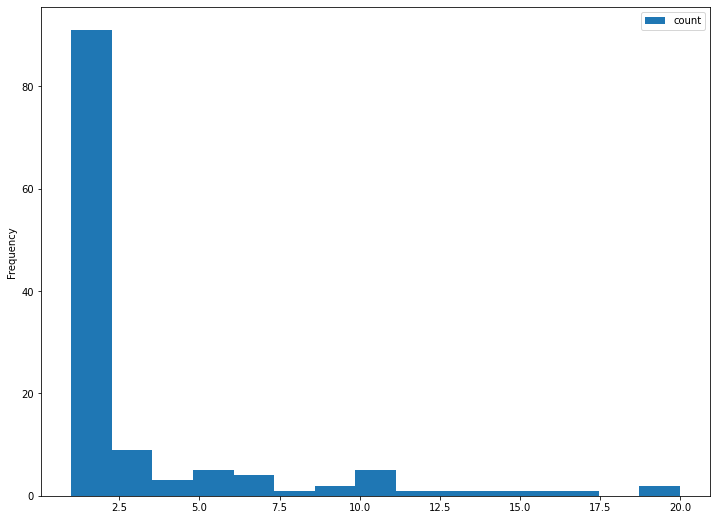

In [684]:
# plotando gráfico de histograma da distribuição da variável MPG
mpg_df = carsRDD.groupBy('MPG').count().sort('MPG', ascending=False)
mpg_df.toPandas().plot.hist(x='MPG', bins=15, figsize=(12, 9));

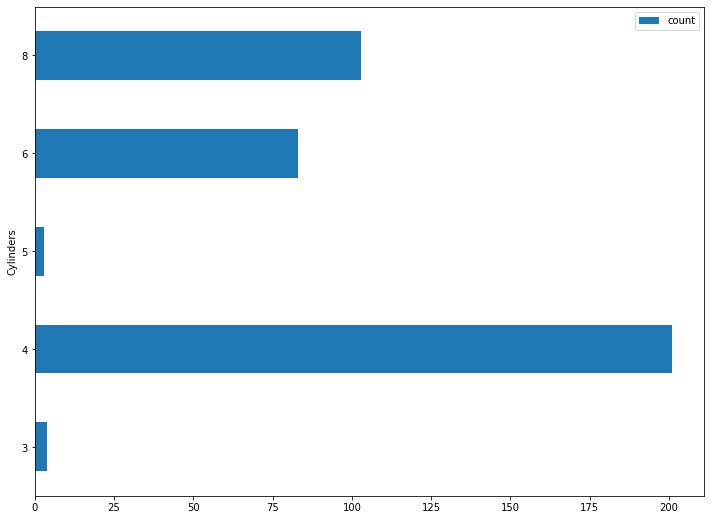

In [685]:
# plotando gráfico de barras da distribuição da variável Cylinders
cylinders_df = carsRDD.groupBy('Cylinders').count().sort('Cylinders', ascending=True)
cylinders_df.toPandas().plot.barh(x='Cylinders', figsize=(12, 9));

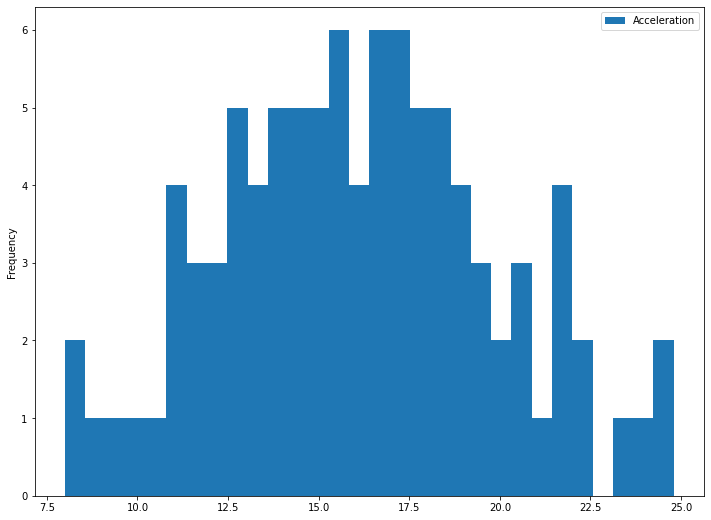

In [686]:
# plotando gráfico de histograma da distribuição da variável Acceleration
acceleration_df = carsRDD.groupBy('Acceleration').count().sort('Acceleration', ascending=True)
acceleration_df.toPandas().plot.hist(y='Acceleration', bins=30, figsize=(12, 9));

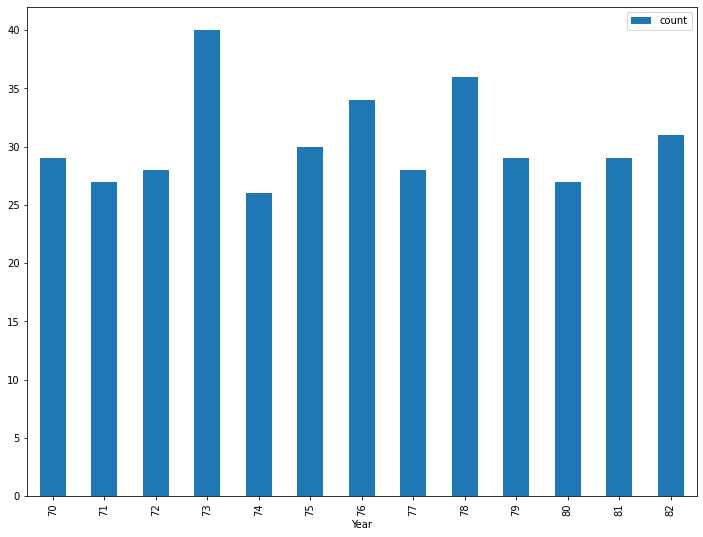

In [687]:
# plotando gráfico de barras da distribuição da variável Year
year_df = carsRDD.groupBy('Year').count().sort('Year', ascending=True)
year_df.toPandas().plot.bar(x='Year', figsize=(12, 9));

In [688]:
# importando a biblioteca para análise estatísticas
from pyspark.mllib.stat import Statistics as Stat

In [689]:
# visualizando instâncias únicas da coluna MPG
carsRDD.select('MPG').distinct().sort('MPG', ascending=True).show()

+----+
| MPG|
+----+
| 9.0|
|10.0|
|11.0|
|12.0|
|13.0|
|14.0|
|14.5|
|15.0|
|15.5|
|16.0|
|16.2|
|16.5|
|16.9|
|17.0|
|17.5|
|17.6|
|17.7|
|18.0|
|18.1|
|18.2|
+----+
only showing top 20 rows



In [690]:
# visualizando dados estatísticos somente da coluna "mpg" (milhas por galão)
carsRDD.select('MPG').describe().show()

+-------+-----------------+
|summary|              MPG|
+-------+-----------------+
|  count|              394|
|   mean|23.47284263959391|
| stddev|7.805051443209992|
|    min|              9.0|
|    max|             46.6|
+-------+-----------------+



In [691]:
# analisando a distribuição do "mpg" (milhas por galão) por faixas de valores
# para essa análise, criarei faixas de valores e contabilizarei as instâncias
    # até 20
    # entre 20 até 30
    # maior que 30

# criando as seleções

# até 20
mpg_smaller_20 = carsRDD[carsRDD['MPG'] <= 20].count()

# entre 20 até 30
mpg_between_20_until_30 = carsRDD[carsRDD['MPG'] > 20] and carsRDD[carsRDD['MPG'] <= 30].count()

# maior que 30
mpg_above_30 = carsRDD[carsRDD['MPG'] > 30].count()

# visualizando as faixas criadas
mpg_smaller_20, mpg_between_20_until_30, mpg_above_30

(160, 310, 84)

**Aplicando o `K-Means`**

In [692]:
# importando as bibliotecas
from pyspark.ml.evaluation import ClusteringEvaluator   # para a avaliação em cada um dos clusters
from pyspark.ml.clustering import KMeans                # para a criação do modelo de clusterização utilizando o K-means
from pyspark.ml.feature import VectorAssembler          # para transformar os dados em vetores de características 

In [693]:
# nome das colunas
carsRDD.columns

['Model',
 'MPG',
 'Cylinders',
 'Displacement',
 'Horsepower',
 'Weight',
 'Acceleration',
 'Year',
 'Origin']

In [694]:
# tipo de dado das colunas
carsRDD.printSchema()

root
 |-- Model: string (nullable = true)
 |-- MPG: double (nullable = true)
 |-- Cylinders: integer (nullable = true)
 |-- Displacement: double (nullable = true)
 |-- Horsepower: string (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Acceleration: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Origin: string (nullable = true)



In [695]:
# criando os vetores

vecAssembler = VectorAssembler(inputCols=['MPG', 'Cylinders', 'Displacement',
                                          'Weight', 'Acceleration'], 
                               outputCol='features')    # utilizada para transformar os dados em um vetor (define o objeto)

new_df = vecAssembler.transform(carsRDD)   # aplicando a transformação

# visualizando a variável
new_df.show()

+--------------------+----+---------+------------+----------+------+------------+----+------+--------------------+
|               Model| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Year|Origin|            features|
+--------------------+----+---------+------------+----------+------+------------+----+------+--------------------+
|chevrolet chevell...|18.0|        8|       307.0|       130|  3504|        12.0|  70|    US|[18.0,8.0,307.0,3...|
|   buick skylark 320|15.0|        8|       350.0|       165|  3693|        11.5|  70|    US|[15.0,8.0,350.0,3...|
|  plymouth satellite|18.0|        8|       318.0|       150|  3436|        11.0|  70|    US|[18.0,8.0,318.0,3...|
|       amc rebel sst|16.0|        8|       304.0|       150|  3433|        12.0|  70|    US|[16.0,8.0,304.0,3...|
|         ford torino|17.0|        8|       302.0|       140|  3449|        10.5|  70|    US|[17.0,8.0,302.0,3...|
|    ford galaxie 500|15.0|        8|       429.0|       198|  4341|        10.0

In [696]:
# aplicando o processo de clusterização

# definindo a quantidade de clusters e a semente de aleatoriedade
kmeans = KMeans(k=5, seed=111)  # cluster de 5 | seed de 111

# realizando o treinamento do modelo
model = kmeans.fit(new_df.select('features'))

In [697]:
# criando um dataset com a indicação sobre qual cluster
# que cada instância foi definida
df_final = model.transform(new_df)
df_final.show()

+--------------------+----+---------+------------+----------+------+------------+----+------+--------------------+----------+
|               Model| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Year|Origin|            features|prediction|
+--------------------+----+---------+------------+----------+------+------------+----+------+--------------------+----------+
|chevrolet chevell...|18.0|        8|       307.0|       130|  3504|        12.0|  70|    US|[18.0,8.0,307.0,3...|         4|
|   buick skylark 320|15.0|        8|       350.0|       165|  3693|        11.5|  70|    US|[15.0,8.0,350.0,3...|         4|
|  plymouth satellite|18.0|        8|       318.0|       150|  3436|        11.0|  70|    US|[18.0,8.0,318.0,3...|         3|
|       amc rebel sst|16.0|        8|       304.0|       150|  3433|        12.0|  70|    US|[16.0,8.0,304.0,3...|         3|
|         ford torino|17.0|        8|       302.0|       140|  3449|        10.5|  70|    US|[17.0,8.0,302.0,3...|    

In [698]:
# contabilizando a quantidade de instâncias de cada cluster
# df_final.groupby('prediction').count().show()
df_final.groupby('prediction').count().sort('prediction', ascending=True).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   85|
|         1|   50|
|         2|  122|
|         3|   78|
|         4|   59|
+----------+-----+



In [699]:
# transformando os dados em um dataframe do pandas 
data_pandas = df_final.toPandas()   # não setando o índice
data_pandas.head(15)

,Model,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,features,prediction
0,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,US,"[18.0, 8.0, 307.0, 3504.0, 12.0]",4
1,buick skylark 320,15.0,8,350.0,165,3693,11.5,70,US,"[15.0, 8.0, 350.0, 3693.0, 11.5]",4
2,plymouth satellite,18.0,8,318.0,150,3436,11.0,70,US,"[18.0, 8.0, 318.0, 3436.0, 11.0]",3
3,amc rebel sst,16.0,8,304.0,150,3433,12.0,70,US,"[16.0, 8.0, 304.0, 3433.0, 12.0]",3
4,ford torino,17.0,8,302.0,140,3449,10.5,70,US,"[17.0, 8.0, 302.0, 3449.0, 10.5]",3
5,ford galaxie 500,15.0,8,429.0,198,4341,10.0,70,US,"[15.0, 8.0, 429.0, 4341.0, 10.0]",1
6,chevrolet impala,14.0,8,454.0,220,4354,9.0,70,US,"[14.0, 8.0, 454.0, 4354.0, 9.0]",1
7,plymouth fury iii,14.0,8,440.0,215,4312,8.5,70,US,"[14.0, 8.0, 440.0, 4312.0, 8.5]",1
8,pontiac catalina,14.0,8,455.0,225,4425,10.0,70,US,"[14.0, 8.0, 455.0, 4425.0, 10.0]",1
9,amc ambassador dpl,15.0,8,390.0,190,3850,8.5,70,US,"[15.0, 8.0, 390.0, 3850.0, 8.5]",4


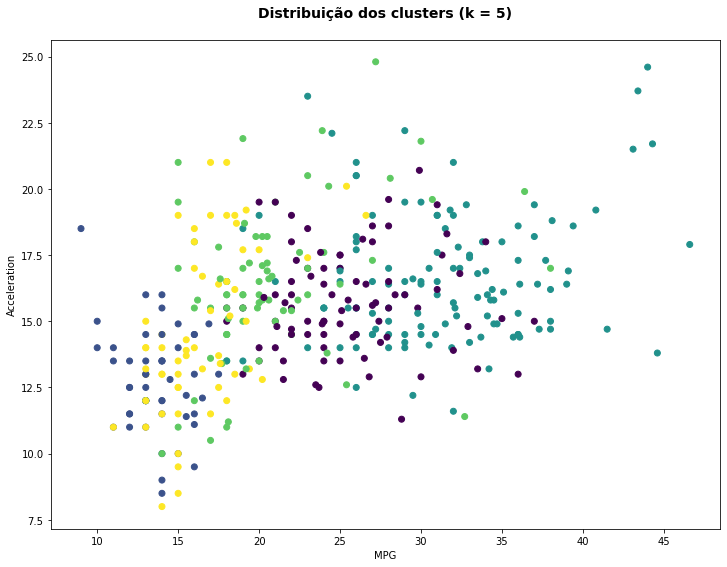

In [700]:
# importando a biblioteca
import matplotlib.pyplot as plt     # para visualização gráfica

# comando mágico para visualização de gráficos dentro do jupyter notebook
%matplotlib inline

plt.figure(figsize=(12, 9))
plt.scatter(data_pandas['MPG'], data_pandas['Acceleration'], 
            c=data_pandas.prediction)

plt.title('Distribuição dos clusters (k = 5)\n', 
         {'fontsize': 14,'fontweight': 'bold'})

plt.xlabel('MPG')
plt.ylabel('Acceleration')

plt.show();

In [701]:
# aplicando o processo de clusterização

# definindo a quantidade de clusters e a semente de aleatoriedade
kmeans = KMeans(k=3, seed=111)  # cluster de 5 | seed de 111

# realizando o treinamento do modelo
model = kmeans.fit(new_df.select('features'))

In [702]:
# criando um dataset com a indicação sobre qual cluster
# que cada instância foi definida
df_final = model.transform(new_df)
df_final.show()

+--------------------+----+---------+------------+----------+------+------------+----+------+--------------------+----------+
|               Model| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Year|Origin|            features|prediction|
+--------------------+----+---------+------------+----------+------+------------+----+------+--------------------+----------+
|chevrolet chevell...|18.0|        8|       307.0|       130|  3504|        12.0|  70|    US|[18.0,8.0,307.0,3...|         2|
|   buick skylark 320|15.0|        8|       350.0|       165|  3693|        11.5|  70|    US|[15.0,8.0,350.0,3...|         2|
|  plymouth satellite|18.0|        8|       318.0|       150|  3436|        11.0|  70|    US|[18.0,8.0,318.0,3...|         2|
|       amc rebel sst|16.0|        8|       304.0|       150|  3433|        12.0|  70|    US|[16.0,8.0,304.0,3...|         2|
|         ford torino|17.0|        8|       302.0|       140|  3449|        10.5|  70|    US|[17.0,8.0,302.0,3...|    

In [703]:
# contabilizando a quantidade de instâncias de cada cluster
# df_final.groupby('prediction').count().show()
df_final.groupby('prediction').count().sort('prediction', ascending=True).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  181|
|         1|   89|
|         2|  124|
+----------+-----+



In [704]:
# transformando os dados em um dataframe do pandas 
data_pandas = df_final.toPandas()   # não setando o índice
data_pandas.head(15)

,Model,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,features,prediction
0,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,US,"[18.0, 8.0, 307.0, 3504.0, 12.0]",2
1,buick skylark 320,15.0,8,350.0,165,3693,11.5,70,US,"[15.0, 8.0, 350.0, 3693.0, 11.5]",2
2,plymouth satellite,18.0,8,318.0,150,3436,11.0,70,US,"[18.0, 8.0, 318.0, 3436.0, 11.0]",2
3,amc rebel sst,16.0,8,304.0,150,3433,12.0,70,US,"[16.0, 8.0, 304.0, 3433.0, 12.0]",2
4,ford torino,17.0,8,302.0,140,3449,10.5,70,US,"[17.0, 8.0, 302.0, 3449.0, 10.5]",2
5,ford galaxie 500,15.0,8,429.0,198,4341,10.0,70,US,"[15.0, 8.0, 429.0, 4341.0, 10.0]",1
6,chevrolet impala,14.0,8,454.0,220,4354,9.0,70,US,"[14.0, 8.0, 454.0, 4354.0, 9.0]",1
7,plymouth fury iii,14.0,8,440.0,215,4312,8.5,70,US,"[14.0, 8.0, 440.0, 4312.0, 8.5]",1
8,pontiac catalina,14.0,8,455.0,225,4425,10.0,70,US,"[14.0, 8.0, 455.0, 4425.0, 10.0]",1
9,amc ambassador dpl,15.0,8,390.0,190,3850,8.5,70,US,"[15.0, 8.0, 390.0, 3850.0, 8.5]",1


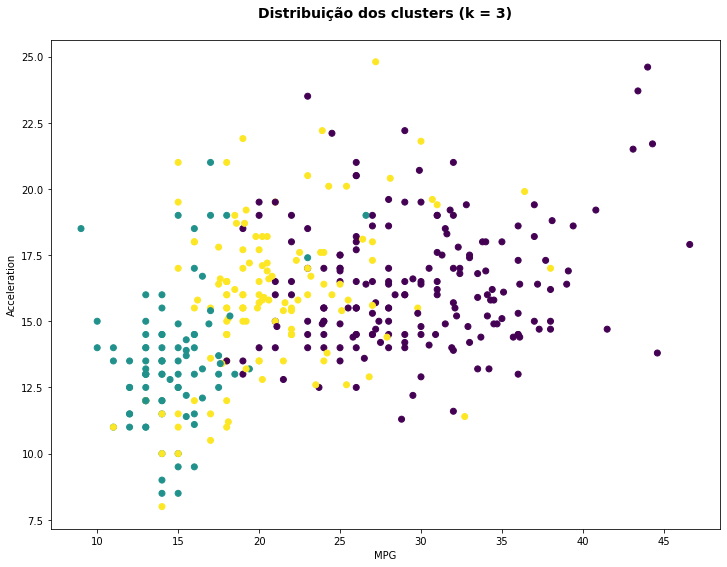

In [705]:
# importando a biblioteca
import matplotlib.pyplot as plt     # para visualização gráfica

# comando mágico para visualização de gráficos dentro do jupyter notebook
%matplotlib inline

plt.figure(figsize=(12, 9))
plt.scatter(data_pandas['MPG'], data_pandas['Acceleration'], 
            c=data_pandas.prediction)

plt.title('Distribuição dos clusters (k = 3)\n', 
         {'fontsize': 14,'fontweight': 'bold'})

plt.xlabel('MPG')
plt.ylabel('Acceleration')

plt.show();